In [3]:
# Package load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

# Bigger and prettier plots
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

In [4]:
with open('model/logistic_regression.pkl', 'rb') as fp:
    logreg = pickle.load(fp)

In [14]:
train_WoE = pd.read_pickle('model/data/train_woe_corr.pkl')
test_WoE = pd.read_pickle('model/data/test_woe_corr.pkl')
performance_df = pd.read_pickle('model/data/performance_loan_profit.pkl')

In [15]:
drop_columns = ['mo_sin_rcnt_rev_tl_op_woe', 'revol_util_woe', 'num_actv_rev_tl_woe']

train_WoE = train_WoE.drop(drop_columns, axis = 1)



In [132]:
performance_df['issue_d']

0         2015-12-01
1         2015-12-01
2         2015-12-01
3         2015-12-01
4         2015-12-01
             ...    
1280610   2016-10-01
1280611   2016-10-01
1280612   2016-10-01
1280613   2016-10-01
1280614   2016-10-01
Name: issue_d, Length: 1280615, dtype: datetime64[ns]

In [149]:
train_WoE['id'] = train_WoE['id'].astype('int')
all_merged = pd.merge(train_WoE, performance_df[['funded_amnt', 'id', 'issue_d']], on=['id'])

In [163]:
loans = pd.DataFrame(all_merged['Default'])

# loans['probs'] = 0
loans['Probs'] = pd.Series(logreg.predict_proba(all_merged.drop(['id', 'Default', 'funded_amnt', 'issue_d'], axis = 1))[:,1])

loans['Portfolio'] = all_merged['issue_d']

In [164]:
loans = loans.groupby(by='Portfolio').mean().reset_index()

# loans['Default'] = loans['Default'].astype('float')

loans.loc[loans['Default']>0.5, 'Default'] = 1
loans.loc[loans['Default']<0, 'Default'] = 0


In [165]:
# #PD Calibration: The PD calibration can be done with the score, the monthly portfolio each case belongs to (usually the behavioural scorecard is used), the labels (Default / Non-Default) and a set of economic factors. For this work we will use an exchange rate and a commodity price.


# # loans = pd.read_excel('PDCalExample.xlsx',sheet_name=0)
# econ_factors = pd.read_excel('PDCalExample.xlsx',sheet_name=1)
# econ_factors=econ_factors.apply(zscore)
# fpr, tpr, thresholds = roc_curve(loans['Default'],loans['Probs'])
# import pwlf
# piecewise_AUC = pwlf.PiecewiseLinFit(fpr, tpr)
# res = piecewise_AUC.fit(10)
# cuts = piecewise_AUC.fit_with_breaks(res)
# # predict for the determined points
# xHat = np.linspace(min(fpr), max(fpr), num=10000)
# yHat = piecewise_AUC.predict(xHat)
# # Find probability associated with every cut
# ROC_curve = pd.DataFrame({'fpr': fpr, 'threshold': thresholds})
# pbb_cuts = np.zeros_like(res)
# i = 0
# for fpr in res:
#   temp = ROC_curve.loc[np.round(ROC_curve.fpr, 2) == np.round(fpr, 2), 'threshold']
#   pbb_cuts[i] = np.mean(temp)
#   i += 1
# pbb_cuts = np.flip(pbb_cuts)
# pbb_cuts = np.append(pbb_cuts, 1)
# pbb_cuts = np.insert(pbb_cuts, 0, 0)
# pd_cut = pd.cut(loans['Probs'], pbb_cuts)
# # Create table with cases total.
# PDs_Tab = pd.crosstab(pd_cut,loans['Default'],normalize = False)
# # Calculate default rate.
# pd_final = PDs_Tab[1] / (PDs_Tab[0] + PDs_Tab[1])#The PD is perfectly monotonous!
# # Adjusted cuts
# pbb_cuts = [0.00000000e+00, 2.28978031e-01, # Delete first cut
#             3.43684010e-01, 4.29913660e-01, 5.55186700e-01, 6.94758101e-01,
#             7.51302438e-01, 8.26511005e-01, 9.11724503e-01, 9.82918518e-01,
#             1.00000000e+00]

# # Add the PDCut variable to our dataframe
# loans['PD_Cut'] = pd.cut(loans['Probs'], pbb_cuts)

# # Create pivot table
# PD_monthly = pd.pivot_table(loans,
#                             values = 'Default',
#                             index = 'Portfolio',
#                             columns = 'PD_Cut',
#                             aggfunc = np.mean
#                             )#Now we have calculated the PDs for all ratings! 

# #Let's plot how our ratings look like
# PD_monthly.plot(subplots=True,
#           layout=(2, 5),
#           sharex=False,
#           sharey=False,
#           colormap='viridis',
#          fontsize=8,
#          legend=False,
#          linewidth=0.2);
# plt.tight_layout();
# #Estimating Long-Term PD
# from datetime import date
# from dateutil.relativedelta import *

# start_date = date(1999, 1, 1)
# PD_monthly.index = [pd.to_datetime(start_date + relativedelta(months=+portfolio_month-1)) for portfolio_month in PD_monthly.index] 
# econ_factors.index = [pd.to_datetime(start_date + relativedelta(months=+portfolio_month-1)) for portfolio_month in econ_factors.index] 
# econ_factors.drop(columns='Portfolio', inplace = True)
# #Now we can decompose our time series to see what is happening.
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition = seasonal_decompose(PD_monthly.iloc[:, 4], model='additive')
# fig = decomposition.plot()
# plt.show()
# #Let's search for the best model for a rating, searching between 1 and 6 autoregression factors, using the macroeconomic factors as the exogenous variables:
# # Define the search space.
# p = range(1, 6)
# d = range(0, 2)
# q = range(0, 2)

# # Create an interative list of ps, ds, qs.
# from itertools import product
# pdq = list(product(p, d, q))

# # Seasonal parameters. One year back.
# ps = range(0, 4)
# ds = range(0, 1)
# qs = range(0, 1)
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# # Train the models for a series and test multiple values.
# y = PD_monthly.iloc[:, 4] # Choose the fifth rating

# from statsmodels.tsa.statespace.sarimax import SARIMAX

# auc_out = []

# for param in pdq:
#   for param_seasonal in seasonal_pdq:
#       mod = SARIMAX(y,
#                     exog=np.asarray(econ_factors),
#                     order=param,
#                     seasonal_order=param_seasonal,
#                     enforce_stationarity=False,
#                     enforce_invertibility=False
#                     )
#       results = mod.fit()
#       auc_out.append([param, param_seasonal, results.aic])
#       print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
# # ARIMA(5, 0, 1)x(0, 0, 0, 12)12
# mod_BB = SARIMAX(y,
#               exog=np.asarray(econ_factors),
#               order=(5,0,1),
#               seasonal_order=(0,0,0,12),
#               enforce_stationarity=False,
#               enforce_invertibility=False)
# results_BB = mod_BB.fit()

# print(results_BB.summary().tables[1])
# # ARIMA(4, 1, 1)x(0, 0, 0, 12)12
# mod_BB = SARIMAX(y,
#               exog=np.asarray(econ_factors),
#               order=(4,1,1),
#               seasonal_order=(0,0,0,12),
#               enforce_stationarity=False,
#               enforce_invertibility=False)
# results_BB = mod_BB.fit()

# print(results_BB.summary().tables[1])#We pick the one that minimizes the AIC, which is ARIMA(1, 0, 1)x(0, 0, 0, 12).


In [147]:
from scipy.stats import zscore
econ_factors=econ_factors.apply(zscore)
econ_factors.describe()

NameError: name 'econ_factors' is not defined

In [166]:
loans

,Portfolio,Default,Probs
0,2007-07-01,0.000000,0.491731
1,2007-08-01,0.384615,0.499652
2,2007-09-01,0.333333,0.477079
3,2007-10-01,0.263158,0.537893
4,2007-11-01,0.428571,0.483602
...,...,...,...
133,2018-08-01,0.013213,0.351436
134,2018-09-01,0.008596,0.352661
135,2018-10-01,0.003732,0.352930
136,2018-11-01,0.001008,0.354695


In [162]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(loans['Default'], 
                                 loans['Probs'])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = loans['Default'], 
                             y_score = loans['Probs']),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Scorecard, auc="+str(auc))
plt.legend(loc=4)
plt.show()

C:\Users\preet\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [90]:
!pip install pwlf

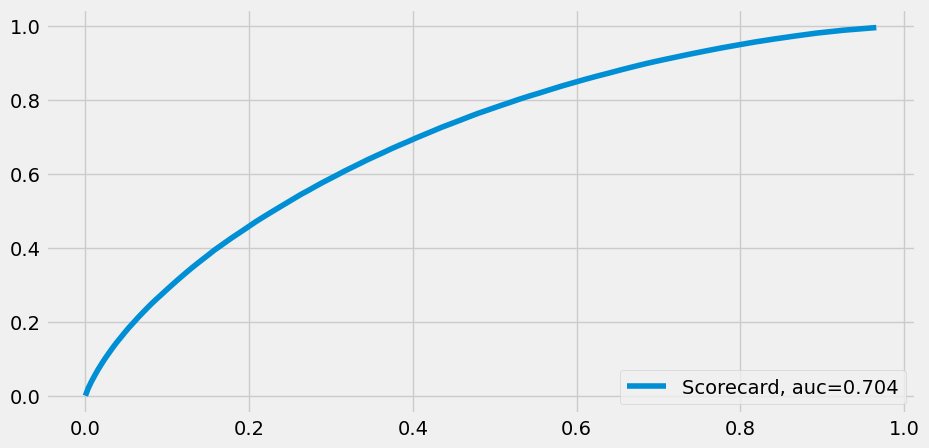

In [117]:
# Create and show the plot
plt.plot(fpr[::3000],tpr[::3000],label="Scorecard, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [118]:
import pwlf

# Define the curve with the ROC curve
piecewise_AUC = pwlf.PiecewiseLinFit(fpr[::3000], tpr[::3000])

In [119]:
# Calculate the best curve. Long!
res = piecewise_AUC.fit(15)

In [120]:
res

array([0.        , 0.0050328 , 0.02186752, 0.04596094, 0.07834134,
       0.12576246, 0.16514527, 0.21178588, 0.26653019, 0.32055587,
       0.37855901, 0.45466003, 0.54769853, 0.66667665, 0.81374305,
       0.96608889])

In [121]:
ROC_curve = pd.DataFrame({'fpr': fpr, 'threshold': thresholds})
ROC_curve

,fpr,threshold
0,0.000000,1.908151
1,0.000000,0.908151
2,0.000000,0.907895
3,0.000004,0.904152
4,0.000004,0.902913
...,...,...
277826,0.999846,0.030270
277827,0.999849,0.030244
277828,0.999948,0.025301
277829,0.999948,0.025197


In [122]:
cuts = piecewise_AUC.fit_with_breaks(res)

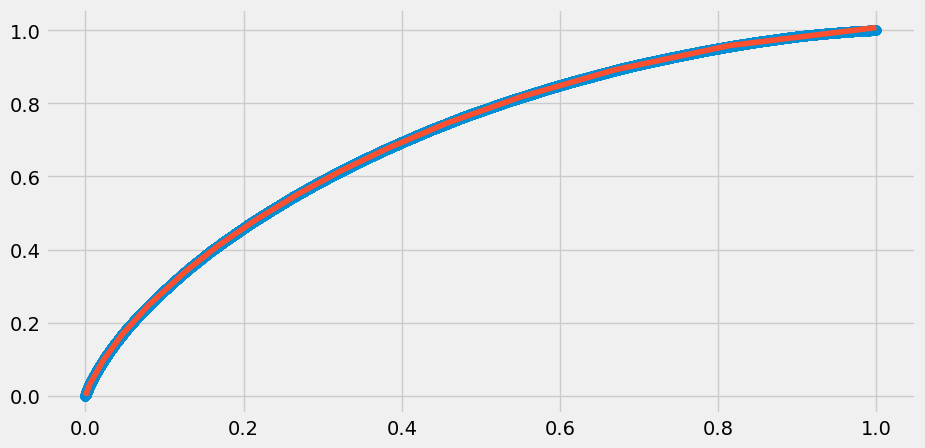

In [123]:
# predict for the determined points
xHat = np.linspace(min(fpr), max(fpr), num=10000)
yHat = piecewise_AUC.predict(xHat)

# plot the results
plt.figure()
plt.plot(fpr, tpr, 'o')
plt.plot(xHat, yHat, '-')
plt.show()

In [124]:
# Find probability associated with every cut
pbb_cuts = np.zeros_like(res)
i = 0

for fpr in res:
    temp = ROC_curve.loc[np.round(ROC_curve.fpr, 2) == np.round(fpr, 2), 'threshold']
    pbb_cuts[i] = np.mean(temp)
    i += 1

pbb_cuts = np.flip(pbb_cuts)

In [125]:
pbb_cuts = np.append(pbb_cuts, 1)
pbb_cuts = np.insert(pbb_cuts, 0, 0)
pbb_cuts

array([0.        , 0.12624994, 0.26945192, 0.35039569, 0.41256617,
       0.46276787, 0.49804383, 0.52910119, 0.55614661, 0.59102311,
       0.61611814, 0.64422535, 0.68622588, 0.71873316, 0.76749288,
       0.79573577, 0.83902923, 1.        ])

In [126]:
pd_cut = pd.cut(loans['Probs'], pbb_cuts)
pd_cut

0          (0.269, 0.35]
1         (0.126, 0.269]
2          (0.269, 0.35]
3         (0.616, 0.644]
4         (0.413, 0.463]
               ...      
896425     (0.269, 0.35]
896426     (0.269, 0.35]
896427    (0.529, 0.556]
896428    (0.616, 0.644]
896429    (0.556, 0.591]
Name: Probs, Length: 896430, dtype: category
Categories (17, interval[float64, right]): [(0.0, 0.126] < (0.126, 0.269] < (0.269, 0.35] < (0.35, 0.413] ... (0.719, 0.767] < (0.767, 0.796] < (0.796, 0.839] < (0.839, 1.0]]

In [127]:
# Create table with cases total.
PDs_Tab = pd.crosstab(pd_cut,
                      loans['Default'],
                      normalize = False)

# Calculate default rate.
print(PDs_Tab)
pd_final = PDs_Tab[1] / (PDs_Tab[0] + PDs_Tab[1])
pd_final

Default              0      1
Probs                        
(0.0, 0.126]     21382    658
(0.126, 0.269]  113270   8008
(0.269, 0.35]    99220  11953
(0.35, 0.413]    84924  14018
(0.413, 0.463]   70864  14498
(0.463, 0.498]   49486  12082
(0.498, 0.529]   42615  11872
(0.529, 0.556]   35303  11048
(0.556, 0.591]   42641  14880
(0.591, 0.616]   28166  11291
(0.616, 0.644]   28427  12683
(0.644, 0.686]   35466  18581
(0.686, 0.719]   21333  13364
(0.719, 0.767]   21209  16835
(0.767, 0.796]    7280   7263
(0.796, 0.839]    5410   6619
(0.839, 1.0]      1415   2366


Probs
(0.0, 0.126]      0.029855
(0.126, 0.269]    0.066030
(0.269, 0.35]     0.107517
(0.35, 0.413]     0.141679
(0.413, 0.463]    0.169841
(0.463, 0.498]    0.196238
(0.498, 0.529]    0.217887
(0.529, 0.556]    0.238355
(0.556, 0.591]    0.258688
(0.591, 0.616]    0.286160
(0.616, 0.644]    0.308514
(0.644, 0.686]    0.343793
(0.686, 0.719]    0.385163
(0.719, 0.767]    0.442514
(0.767, 0.796]    0.499416
(0.796, 0.839]    0.550254
(0.839, 1.0]      0.625760
dtype: float64

In [130]:
# Add the PDCut variable to our dataframe
loans['PD_Cut'] = pd.cut(loans['Probs'], pbb_cuts)

# Create pivot table
PD_monthly = pd.pivot_table(loans,
                            values = 'Default',
                            index = 'Portfolio',
                            columns = 'PD_Cut',
                            aggfunc = np.mean
                            )

PD_monthly

PD_Cut,"(0.0, 0.126]","(0.126, 0.269]","(0.269, 0.35]","(0.35, 0.413]","(0.413, 0.463]","(0.463, 0.498]","(0.498, 0.529]","(0.529, 0.556]","(0.556, 0.591]","(0.591, 0.616]","(0.616, 0.644]","(0.644, 0.686]","(0.686, 0.719]","(0.719, 0.767]","(0.767, 0.796]","(0.796, 0.839]","(0.839, 1.0]"
Portfolio,,,,,,,,,,,,,,,,,
500.0,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
1000.0,0.043478,0.075368,0.081803,0.120527,0.113895,0.175676,0.153226,0.189349,0.190722,0.275641,0.246667,0.245161,0.257732,0.313953,0.285714,0.0,NaN
1025.0,0.000000,NaN,NaN,0.500000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.500000,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39900.0,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39925.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39950.0,NaN,0.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
